# Preparing the data

In [30]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

## Turn unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt']
Slusarski


In [31]:
len(all_categories)

18

In [32]:
category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

# String Names into Tensors

In [33]:
import torch

In [34]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [35]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

print(letterToIndex('R'))
letterToTensor('R')

43


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [36]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        
    return tensor

lineToTensor('Ronit').size()

torch.Size([5, 1, 57])

# Creating the Network

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [38]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0133, -2.9794, -2.8290, -2.8594, -2.8906, -2.9251, -2.9562, -2.9585,
         -2.7974, -2.9246, -2.8809, -2.9079, -2.8569, -2.6591, -2.8480, -2.9181,
         -2.9467, -2.9326]], grad_fn=<LogSoftmaxBackward0>)


# Training

In [39]:
output.topk(1)

torch.return_types.topk(
values=tensor([[-2.6591]], grad_fn=<TopkBackward0>),
indices=tensor([[13]]))

In [40]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [41]:
categoryFromOutput(output)

('Russian', 13)

In [44]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, linen_tensor = randomTrainingExample()
    print('category =', category, '/line =', line)

category = Chinese /line = Tze
category = Vietnamese /line = Trieu
category = French /line = Firmin
category = Greek /line = Karahalios
category = Vietnamese /line = Lac
category = Korean /line = Ku
category = French /line = Rose
category = Spanish /line = Durante
category = Arabic /line = Boulos
category = Portuguese /line = Moreno


# Training the Network

In [45]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [46]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return output, loss.item()

In [49]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s-= m * 60
    return f"{m}, {s}"

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0, 9.230108737945557) 2.6333 Roche / Arabic ✗ (French)
10000 10% (0, 17.77410054206848) 0.7839 Honami / Japanese ✓
15000 15% (0, 25.774410247802734) 1.0598 Romao / Portuguese ✓
20000 20% (0, 33.484941482543945) 0.2511 Malouf / Arabic ✓
25000 25% (0, 41.48354768753052) 0.2172 Assaf / Arabic ✓
30000 30% (0, 49.90408492088318) 1.8193 Mateu / Arabic ✗ (Spanish)
35000 35% (0, 58.24236512184143) 3.1076 Nagai / Arabic ✗ (Japanese)
40000 40% (1, 6.995813846588135) 0.8904 Mifsud / Arabic ✓
45000 45% (1, 15.653111219406128) 1.3312 Hoffmann / Dutch ✗ (German)
50000 50% (1, 24.391373872756958) 0.0086 Paraskevopoulos / Greek ✓
55000 55% (1, 33.027496099472046) 0.4824 Escarra / Spanish ✓
60000 60% (1, 41.27847981452942) 1.1999 Schneider / German ✗ (Dutch)
65000 65% (1, 49.65227031707764) 2.3027 Siskind / English ✗ (German)
70000 70% (1, 57.77586603164673) 1.0799 Polites / Greek ✓
75000 75% (2, 5.785902976989746) 0.2137 Barros / Portuguese ✓
80000 80% (2, 13.924975395202637) 0.2852 Rosario /

# Plotting the results

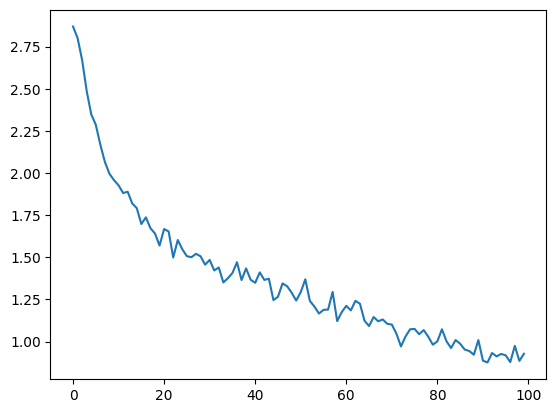

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)